In [1]:
import pandas as pd
import numpy as np
import math
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import (BatchNormalization, Input, Dense, Activation)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow_probability as tfp
import seaborn as sns

pi = math.pi
maxval = 1e9
minval = 1e-9
a = 0.0
b = 1.01

In [2]:
train_df = pd.read_csv('./train1Dy_df.csv')
test_df = pd.read_csv('./test1Dy_df.csv')
print(train_df.shape, test_df.shape)

(1991564, 16) (125498, 16)


In [3]:
def inverse_cot(cota):
    a = np.arctan(1/cota)
    a[np.where(a<0)] = a[np.where(a<0)]+pi
    return a

In [4]:
X_train = train_df.drop(columns=['y-local','y-midplane','cotBeta']).values
X_test = test_df.drop(columns=['y-local','y-midplane','cotBeta']).values

y_train = inverse_cot(abs(train_df['cotBeta'].values))*2/pi
y_test = inverse_cot(abs(test_df['cotBeta'].values))*2/pi

/var/folders/w1/wy8xldzx1nsdnpwxfmx7lz3w0000gn/T/ipykernel_4457/2672626872.py:2: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(1/cota)


In [5]:
X_train = X_train.reshape(-1, X_train.shape[-1])
X_test = X_test.reshape(-1, X_test.shape[-1])

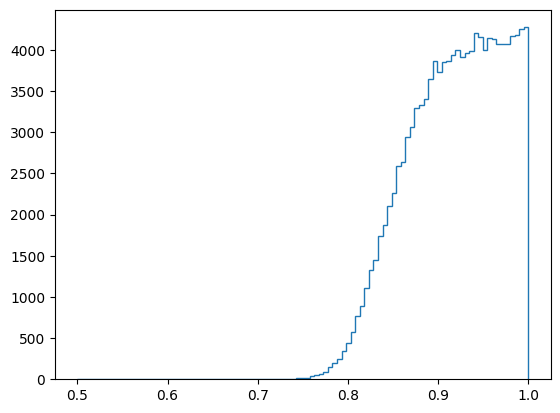

In [6]:
plt.hist(y_test,bins=np.linspace(0.5,1,100), histtype = 'step');

In [7]:
def param_transform(par):
    return minval+tf.math.softplus(par)


def log_beta(x, alpha, beta, a=a, b=b):
    # x in (0, 1), alpha > 0, beta > 0, a < x < b
    return (alpha - 1.)*tf.math.log(x - a) + (beta - 1.)*tf.math.log(b - x + 1e-6) \
            - tf.math.lgamma(alpha) - tf.math.lgamma(beta) + tf.math.lgamma(alpha + beta) \
            - (alpha + beta - 1.)*tf.math.log(b - a)

def beta_loss(y, p):
    
    alpha = param_transform(tf.gather(params=p, indices=[0], axis=1))
    beta = param_transform(tf.gather(params=p, indices=[1], axis=1))
    
    NLL = -1*log_beta(y, alpha, beta)
    return tf.keras.backend.sum(NLL,axis=1)

In [8]:
def CreateBatNaN(shape):
    x = x_in = Input(shape)
    x = Dense(64, name="dense1")(x)
    x = Activation("relu", name="relu1")(x)
    x = BatchNormalization()(x)
    x = Dense(64, name="dense2")(x)
    x = Activation("relu", name="relu2")(x)
    x = BatchNormalization()(x)
    x = Dense(64, name="dense3")(x)
    x = Activation("relu", name="relu3")(x)
    x = BatchNormalization()(x)
    x = Dense(2, name="dense4")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

model=CreateBatNaN(X_train.shape[1:])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss=beta_loss)

model.summary()

Metal device set to: Apple M1


2023-02-17 13:22:52.840465: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-17 13:22:52.840482: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense1 (Dense)              (None, 64)                896       
                                                                 
 relu1 (Activation)          (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense2 (Dense)              (None, 64)                4160      
                                                                 
 relu2 (Activation)          (None, 64)                0         
                                                             

In [9]:
es = EarlyStopping(patience=20,
                  restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=100, 
                    batch_size=2048,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

2023-02-17 13:22:53.040273: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100


2023-02-17 13:22:53.422034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


778/778 [==============================] - ETA: 0s - loss: -1.3592

2023-02-17 13:23:06.976536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


778/778 [==============================] - 15s 18ms/step - loss: -1.3592 - val_loss: -1.8989
Epoch 2/100
778/778 [==============================] - 14s 18ms/step - loss: -2.1129 - val_loss: -2.2183
Epoch 3/100
778/778 [==============================] - 14s 18ms/step - loss: -2.3445 - val_loss: -2.4162
Epoch 4/100
778/778 [==============================] - 14s 18ms/step - loss: -2.4415 - val_loss: -2.4075
Epoch 5/100
778/778 [==============================] - 14s 18ms/step - loss: -2.4847 - val_loss: -2.5210
Epoch 6/100
778/778 [==============================] - 14s 18ms/step - loss: -2.5081 - val_loss: -2.5014
Epoch 7/100
778/778 [==============================] - 14s 18ms/step - loss: -2.5209 - val_loss: -2.5461
Epoch 8/100
778/778 [==============================] - 14s 18ms/step - loss: -2.5310 - val_loss: -2.5475
Epoch 9/100
778/778 [==============================] - 14s 18ms/step - loss: -2.5379 - val_loss: -2.5101
Epoch 10/100
778/778 [==============================] - 14s 18ms/st

778/778 [==============================] - 14s 18ms/step - loss: -2.5986 - val_loss: -2.6125
Epoch 79/100
778/778 [==============================] - 14s 18ms/step - loss: -2.5991 - val_loss: -2.6533
Epoch 80/100
778/778 [==============================] - 14s 18ms/step - loss: -2.5991 - val_loss: -2.6107
Epoch 81/100
778/778 [==============================] - 14s 18ms/step - loss: -2.5993 - val_loss: -2.6399
Epoch 82/100
778/778 [==============================] - 14s 18ms/step - loss: -2.5994 - val_loss: -2.6383
Epoch 83/100
778/778 [==============================] - 14s 18ms/step - loss: -2.5997 - val_loss: -2.6528
Epoch 84/100
778/778 [==============================] - 14s 18ms/step - loss: -2.6002 - val_loss: -2.6485
Epoch 85/100
778/778 [==============================] - 14s 18ms/step - loss: -2.6006 - val_loss: -2.6356
Epoch 86/100
778/778 [==============================] - 14s 18ms/step - loss: -2.6008 - val_loss: -2.6080
Epoch 87/100
778/778 [==============================] - 14s

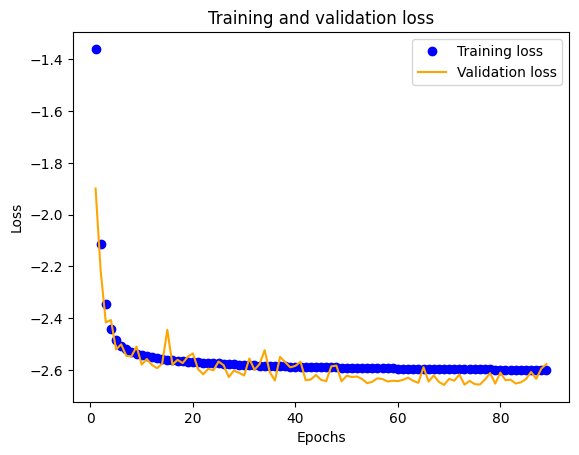

In [10]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.yscale('Log')
plt.legend()
plt.show()

In [11]:
p_test = model.predict(X_test, batch_size= 512)
df = pd.DataFrame(p_test,columns=['par1','par2'])
df['Btrue'] = y_test*pi/2
df['alpha'] = param_transform(df['par1'])
df['beta'] = param_transform(df['par2'])

df['mean'] = (df['alpha']/ (df['alpha']+ df['beta']))*(b-a)
df['mode'] = a + ((df['alpha'] - 1.0)/ (df['alpha']+df['beta']-2.0))*(b-a)

df['var'] = (((df['alpha']*df['beta'])*(b-a)**2))/((df['alpha']+df['beta']+1.0)*(df['alpha']+df['beta'])**2)
df['sigma'] = np.sqrt(df['var'])
# dist = tfp.distributions.Beta(concentration1 = df['alpha'], concentration0 = df['beta'])
    
df['mean'] = df['mean']*pi/2
df['mode'] = df['mode']*pi/2
df['sigma'] = df['sigma']*pi/2

# df.to_csv("test_1DcotABeta.csv",header=False,index=False)

 47/246 [====>.........................] - ETA: 0s

2023-02-17 13:43:47.458696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


246/246 [==============================] - 1s 2ms/step


In [12]:
residuals = df['Btrue'] - df['mode']
print(np.mean(residuals),np.std(residuals))

-0.008318416708854939 0.030589590129298506


/var/folders/w1/wy8xldzx1nsdnpwxfmx7lz3w0000gn/T/ipykernel_4457/162544794.py:2: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


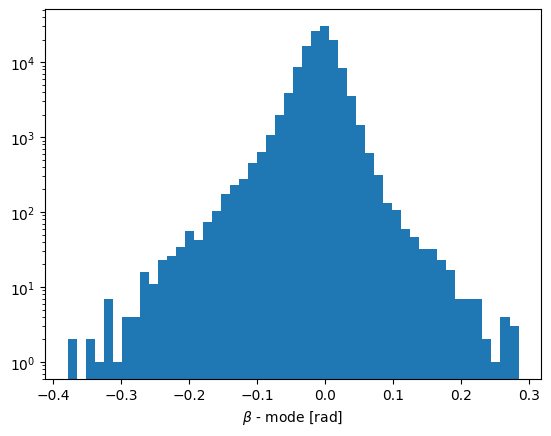

/var/folders/w1/wy8xldzx1nsdnpwxfmx7lz3w0000gn/T/ipykernel_4457/162544794.py:7: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


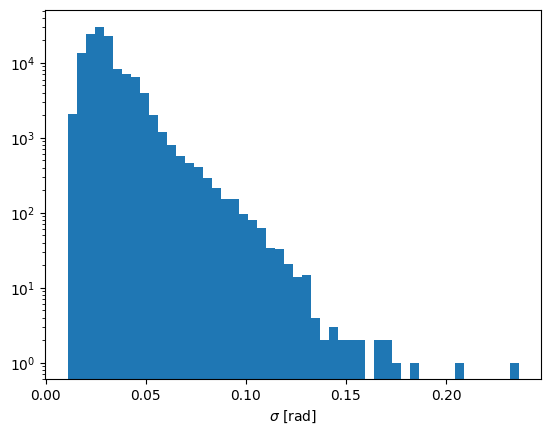

/var/folders/w1/wy8xldzx1nsdnpwxfmx7lz3w0000gn/T/ipykernel_4457/162544794.py:12: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


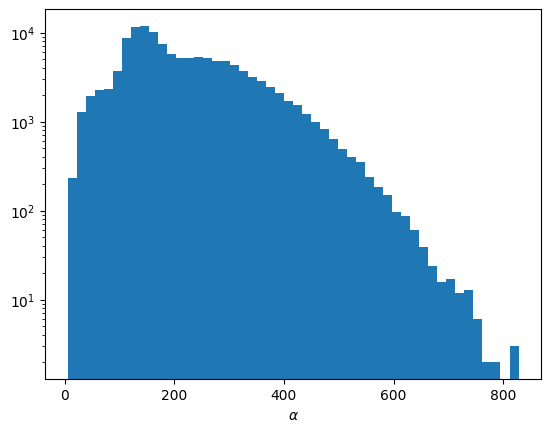

/var/folders/w1/wy8xldzx1nsdnpwxfmx7lz3w0000gn/T/ipykernel_4457/162544794.py:17: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


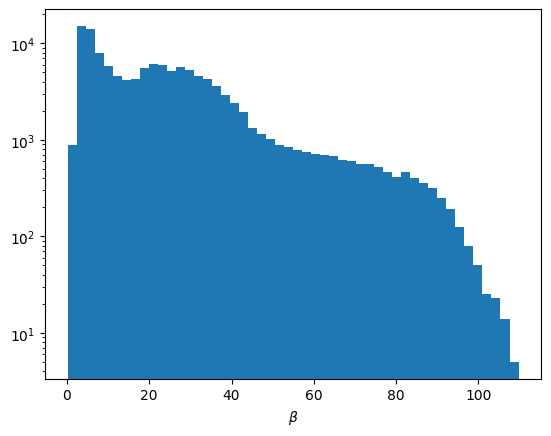

In [13]:
plt.hist(residuals,bins=50)
plt.yscale('Log')
plt.xlabel(r'$\beta$ - mode [rad]')
plt.show()

plt.hist(df['sigma'],bins=50);
plt.yscale('Log')
plt.xlabel(r'$\sigma$ [rad]')
plt.show()

plt.hist(df['alpha'],bins=50)
plt.yscale('Log')
plt.xlabel(r'$\alpha$')
plt.show()

plt.hist(df['beta'],bins=50)
plt.yscale('Log')
plt.xlabel(r'$\beta$')
plt.show()

Text(0, 0.5, 'log(beta)')

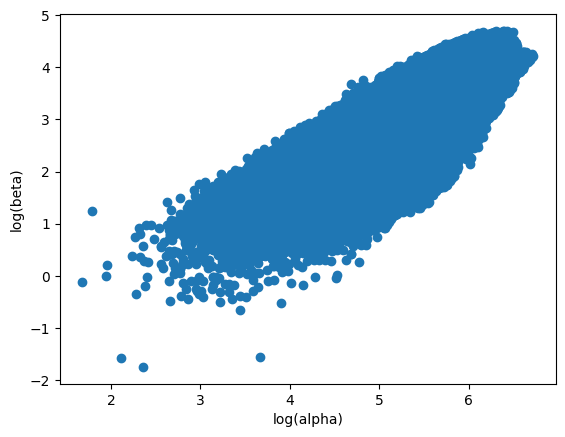

In [14]:
plt.scatter(np.log(df['alpha']),np.log(df['beta']))
plt.xlabel('log(alpha)')
plt.ylabel('log(beta)')

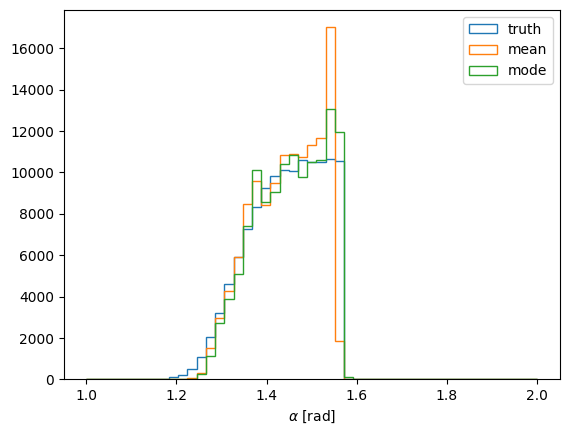

In [15]:
plt.hist(df['Btrue'],bins=np.linspace(1,2,50),histtype='step',label='truth')
plt.hist(df['mean'],bins=np.linspace(1,2,50),histtype='step',label='mean')
plt.hist(df['mode'],bins=np.linspace(1,2,50),histtype='step',label='mode')
# plt.yscale('Log')
plt.xlabel(r'$\alpha$ [rad]')
# plt.xlim([0.0,pi])
plt.legend()
plt.show()

Text(0, 0.5, '$\\alpha$ - mode [rad]')

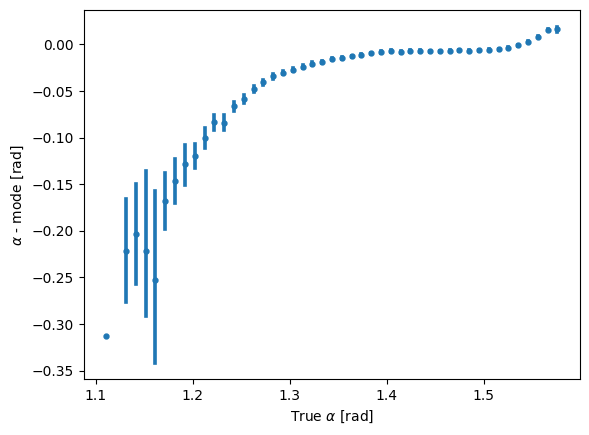

In [16]:
x = sns.regplot(x=df['Btrue'], y=df['Btrue']-df['mode'], x_bins=np.linspace(1,2,100), fit_reg=None, marker='.')
plt.xlabel(r'True $\alpha$ [rad]')
plt.ylabel(r'$\alpha$ - mode [rad]')

Text(0, 0.5, '$\\sigma$ [rad]')

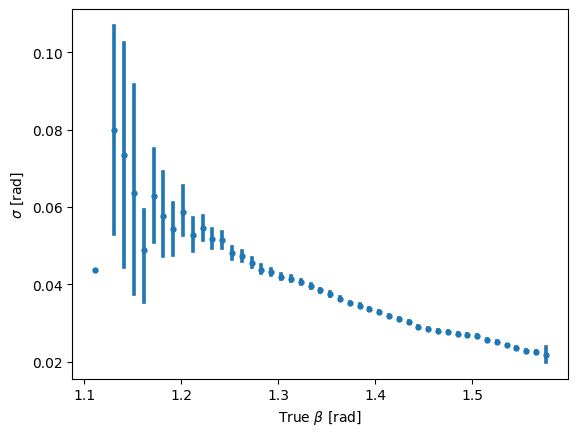

In [17]:
y = sns.regplot(x=df['Btrue'], y=df['sigma'], x_bins=np.linspace(1,2,100), fit_reg=None, marker='.')
plt.xlabel(r'True $\beta$ [rad]')
plt.ylabel(r'$\sigma$ [rad]')

-0.26310028477178016 0.913080019196259


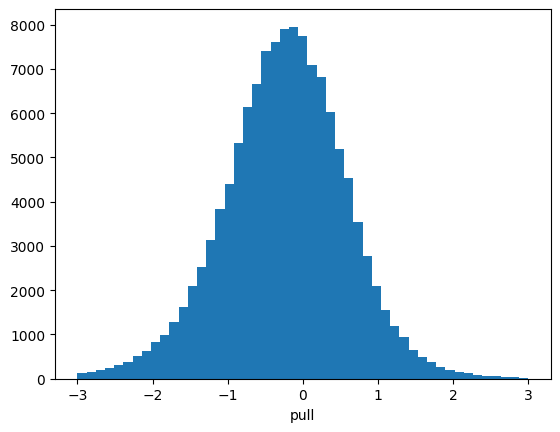

In [18]:
pulls = residuals/df['sigma']
print(np.mean(pulls),np.std(pulls))
plt.hist(pulls,bins=np.linspace(-3,3,50));
plt.xlabel('pull')
plt.show()